In [1]:
#Universidad Nacional Autónoma de México
#Posgrado en Ciencias de la Tierra 
#Campo 1, Geofísica de la Tierra sólida, Sismología

#Elaborado por Isaac Valverde, 2022

#Programa 2: Notebook de Python 3 que realiza la resolición del ejemplo incluido en Nocquet (2018) de un caso sintético usando la estrategia semianalítica que propone así como el método MCMC 
#Referencia: Nocquet, J.-M. (2018). Stochastic static fault slip inversion from geodetic data with non-negativity and bound constraints. Geophysical Journal International, 214 (1), 366–385. 2, 13, 24, 26, 27

In [2]:
from scipy.stats.mvn import mvnun
import numpy as np
from scipy.stats import norm
from scipy.stats import truncnorm
import matplotlib.pyplot as plt
import time

In [3]:
#Función que evalúa una pdf normal bidimensional de los residuos (verosimilitud)
#Entradas
#m1: Valor del parámetro 1
#m2: Valor del parámetro 2
#G: Arreglo numpy (Matriz de (número de datos)x(número de parámetros) que corresponde al kernel de la inversión).
#d: Arreglo numpy (vector columna) que contiene las observaciones.
#Cdinv: Arreglo numpy que corresponde a la inversa de la matriz de covarianza de los datos.
#Kd: Factor de normalización para la pdf normal correspondiente a la verosimilitud.
#Salida
#sigmlk: Logaritmo natural de la muestra de la verosimilitud.

def likelihood(m1,m2,G,d,Cdinv,Kd):
    #Se obtiene el producto de G por m (datos calculados a partir del modelo directo)
    Gm=np.matmul(G,np.array([[m1],[m2]]))
    sigmlk0=Kd*np.exp(-0.5*np.matmul(np.matmul(np.transpose(Gm-d),Cdinv),(Gm-d)))
    #Se obtiene el logaritmo natural de la muestra
    sigmlk=np.log(sigmlk0[0])
    return sigmlk

In [4]:
#Función que evalúa una pdf normal bidimensional para los parámetros (apriori)
#Entradas
#m1: Valor del parámetro 1 
#m2: Valor del parámetro 2
#m0: Arreglo numpy que corresponde al Vector (columna) que contiene la media de la TNVM 
#Cminv: Arreglo numpy que corresponde a la inversa de la matriz de covarianza de los parámetros
#Km: Constante de normalización para la TMVN
#Salida
#sigmap: Muestra de la apriori.

def apriori(m1,m2,m0,Cminv,Km):
    #Se construye un arreglo numpy con los parámetros 
    m=np.array([[m1],[m2]])
    sigmap0=Km*np.exp(-0.5*np.matmul(np.matmul(np.transpose(m-m0),Cminv),(m-m0)))
    #Se obtiene el logaritmo natural de la muestra
    sigmap=np.log(sigmap0[0])
    return sigmap

In [5]:
#Función que obtiene una muestra de una pdf posterior calculada a partir de la apriori y la verosimilitud usando el teorema de Bayes
#Entradas
#m1: Valor del parámetro 1 
#m2: Valor del parámetro 2
#G: Arreglo numpy (Matriz de (número de datos)x(número de parámetros) que corresponde al kernel de la inversión).
#d: Arreglo numpy (vector columna) que contiene las observaciones.
#m0: Arreglo numpy que corresponde al Vector (columna) que contiene la media de la TNVM 
#Cdinv: Arreglo numpy que corresponde a la inversa de la matriz de covarianza de los datos.
#Cminv: Arreglo numpy que corresponde a la inversa de la matriz de covarianza de los parámetros.
#Kd: Factor de normalización para la pdf normal correspondiente a la verosimilitud.
#Km: Constante de normalización para la TMVN.
#Salida
#lnposterior: Muestra de la posterior.

def posterior(m1,m2,G,d,m0,Cdinv,Cminv,Kd,Km):
    lnlk=likelihood(m1,m2,G,d,Cdinv,Kd)
    lnp=apriori(m1,m2,m0,Cminv,Km)
    lnposterior=lnlk+lnp
    return lnposterior

In [6]:
#------------------------Datos Nocquet------------------------

#Se define el número de datos 
Nd=3
#Se define el número de parámetros
Nm=2
#Se define la matriz que relaciona los datos con los parámetros 
G=np.array([[-7,-4],[1,10],[2,-11]])
#Se define la transpuesta de la matriz G
GT=np.transpose(G)
#Se define el vector de datos
d=np.array([[10],[3],[-5]])
#Se define la matriz de covarianza de los datos
Cd=(5**2)*np.identity(Nd)

In [7]:
#------------------------Espacio de parámetros------------------------

#Se define el límite inferior de cada parámetro
a1=0
a2=0
#Se define un vector columna con el límite inferior de cada parámetro
a=np.array([[a1],[a2]])
#Se define el límite superior de cada parámetro
b1=1
b2=1
#Se define un vector columna con el límite superior de cada parámetro
b=np.array([[b1],[b2]])
#Se define el espacio de parámetros (m1 y m2)
m1=np.linspace(a1, b1, num=500)
m2=np.linspace(a2, b2, num=500)
#Se define una malla para el dominio del espacio de parámetros
M1,M2=np.meshgrid(m1, m2)
#Se define un vector con la media de los parámetros (pp 372, primer parrafo, tercer renglón)
m0=np.array([[b1/2],[b2/2]])
#Se define un valor de la constante "alpha" para la aproximación
alpha=8
#Se define la desviación estandar (pp 373, primer párrafo, quinto renglón)
sigma=alpha*(b1/2)
#Se define la matriz de covarianza de los parámetros (pp) (pp 372, primer parrafo, segundo renglón)
Cm=(sigma**2)*np.identity(2)

In [8]:
#Se toma un tiempo de inicio para medir el tiempo de ejecución de la estrategia semianalítica (primera parte)
start_sa1=time.perf_counter()

#Se define la inversa de la matriz de covariana de los datos (Matriz de precisión) 
Cdinv=np.linalg.inv(Cd)
#Se define la inversa la matriz de covarianza de los parámetros
Cminv=np.linalg.inv(Cm)

#------------------------Expectativa y matriz de covarianza posterior------------------------

#Se define la matriz de covarianza posterior (Ecuaciones de Tarantola y Valette, pp. 369, Ec. 7)
Cmv=np.linalg.inv(np.matmul(np.matmul(GT,Cdinv),G)+Cminv)
#Se define la transpuesta de la matriz de covarianza posterior
CmvT=np.transpose(Cmv)
#Se define la inversa de la matriz de covarianza posterior
Cmvinv=np.matmul(np.matmul(GT,Cdinv),G)+Cminv
#Se define la expectativa (Ecuaciones de Tarantola y Valette, pp. 369, Ec. 6)
mv=np.matmul(np.linalg.inv(np.matmul(np.matmul(GT,Cdinv),G)+Cminv), np.matmul(np.matmul(GT,Cdinv),d)+np.matmul(Cminv,m0))

#------------------------Integral de exp(-S(m))------------------------

#Se hace el cálculo de la integral (Para la ecuación en función de la expectativa y la matriz de covarianza posterior)
I=mvnun(a,b,mv,Cmv)
#Se obtiene el factor de normalización de la distribución normal
Inorm=1/((np.linalg.det(Cmv))*(2*np.pi)**(Nm))**(0.5)
#Se define el término que corresponde a la multiplicación de la matriz G con el vector m0
Gm0=np.matmul(G,m0)
#Se define el factor K0 para el cálculo de las marginales (pp. 369, segundo parrafo, primer renglón)
K0=np.matmul(np.matmul(np.transpose(Gm0-d),np.linalg.inv(np.matmul(np.matmul(G,Cm),GT)+Cd)),(Gm0-d))
#Se define el factor de normalización kb (definido bajo la ecuación 5, pp. 368) (La exponencial de -Ko/2 viene de calcular la integral usando la forma de obtener S(m) mostrada en el apendice B1)
kb=(Inorm)/(I[0]*np.exp(-K0/2))
#Se define un parámetro Kb para el cálculo de las marginales para los parámetros m1 y m2 (definido bajo la ecuación 9, pp. 369)
Kb=kb*np.exp(-K0/2)

#Se toma el tiempo final para medir el tiempo de ejecución de la estrategia semianalítica (primera parte)
end_sa1=time.perf_counter()
#Se calcula el tiempo de ejecución de la estrategia semianalítica (primera parte) 
t_sa1=end_sa1-start_sa1

In [9]:
#--------------Cálculo de la PDF posterior conjunta--------------

#Se define un arreglo para la posterior
sigmMb=np.zeros([len(m1),len(m2)])

#Se toma un tiempo de inicio para medir el tiempo de ejecución de la estrategia semianalítica (segunda parte, PDF posterior conjunta)
start_sa2=time.perf_counter()

for i in range(0,len(m1)):
    for j in range (0,len(m2)):
        #Cálculo de la posterior (ecuación 9, pag. 369) 
        sigmMb[j,i]=Kb*np.exp(-0.5*np.matmul(np.matmul(np.transpose(np.array([[m1[i]],[m2[j]]])-mv),Cmvinv),(np.array([[m1[i]],[m2[j]]])-mv)))
        
#Se toma el tiempo final para medir el tiempo de ejecución de la estrategia semianalítica (segunda parte)
end_sa2=time.perf_counter()
#Se calcula el tiempo de ejecución de la estrategia semianalítica (segunda parte)
t_sa2=end_sa2-start_sa2
        

In [10]:
#--------------Marginales (figuras g y h)--------------

#Se define un arreglo para la marginal del parámetro 1
sigmMb1=np.zeros([1,len(m1)])
#Se define un arreglo para la marginal del parámetro 2
sigmMb2=np.zeros([1,len(m2)])

#Se toma un tiempo de inicio para medir el tiempo de ejecución de la estrategia semianalítica (tercera parte, PDFs posteriores marginales)
start_sa3=time.perf_counter()

#Se define el parámetro "A" para el cálculo de la marginal de m1 (pagina 369, tercera ecuación bajo la ecuación 10)
A1=Cmv[1,1]-CmvT[0,1]*(1/Cmv[0,0])*Cmv[0,1]
#Se define el parámetro "A" para el cálculo de la marginal de m2 (desarrollo realizado en la bitácora y definido como "B")
A2=Cmv[0,0]-Cmv[0,1]*(1/Cmv[1,1])*CmvT[0,1]

for i in range(0,len(m1)):
    #Se obtiene el valor de la media para la marginal m1 (pagina 369, cuarta ecuación bajo la ecuación 10) 
    bm1=mv[1][0]+(CmvT[0,1]*(1/Cmv[0,0])*(m1[i]-mv[0][0]))
    #Calculo del factor de normalización para la integral de la distribución normal para m1
    Inormsig1=1/(A1*2*np.pi)**(0.5)
    #Se obtiene el valor de la integral para la marginal de m1 
    Isig1=mvnun(a1,b1,bm1,A1)
    #Se obtiene la marginal para el parámetro 1 (ecuación 11, pag 369)
    sigmMb1[0][i]=Kb[0][0]*np.exp(-0.5*np.transpose(m1[i]-mv[0][0])*(1/Cmv[0,0])*(m1[i]-mv[0][0]))*(Isig1[0]/Inormsig1)
    
    #Se obtiene el valor de la media para la marginal m2 (desarrollo realizado en la bitácora)
    bm2=mv[0][0]+(Cmv[0,1]*(1/Cmv[1,1])*(m2[i]-mv[1][0]))
    #Calculo del factor de normalización para la integral de la distribución normal para m2
    Inormsig2=1/(A2*2*np.pi)**(0.5)
    #Se obtiene el valor de la integral para la marginal de m2 
    Isig2=mvnun(a2,b2,bm2,A2)   
    #Se obtiene la marginal para el parámetro 2
    sigmMb2[0][i]=Kb[0][0]*np.exp(-0.5*np.transpose(m2[i]-mv[1][0])*(1/Cmv[1,1])*(m2[i]-mv[1][0]))*(Isig2[0]/Inormsig2)
        
#Se toma el tiempo final para medir el tiempo de ejecución de la estrategia semianalítica (tercera parte)
end_sa3=time.perf_counter()
#Se calcula el tiempo de ejecución de la estrategia semianalítica (tercera parte)
t_sa3=end_sa3-start_sa3

In [11]:
#Se muestran los tiempos de ejecución de las diferentes partes del proceso y la suma de estas 
print("Tiempo de ejecución estrategia semianalítica 1:",t_sa1)
print("Tiempo de ejecución estrategia semianalítica 2:",t_sa2)
print("Tiempo de ejecución estrategia semianalítica 3:",t_sa3)
print("Tiempo de ejecución estrategia semianalítica:",t_sa1+t_sa2+t_sa3)

Tiempo de ejecución estrategia semianalítica 1: 0.3417403920011566
Tiempo de ejecución estrategia semianalítica 2: 4.250487929999508
Tiempo de ejecución estrategia semianalítica 3: 0.03250869600014994
Tiempo de ejecución estrategia semianalítica: 4.624737018000815


In [12]:
#Se comprueba que la PDF posterior sea una distribución de probabilidad, integrando y buscando obtener un volumen cercano a 1

#Se define un delta de área
dm=(m1[1]-m1[0])**(2)
#Se define una variable auxiliar para sumar el volumen de cada paralelepipedo
aux=0
#Se define un ciclo para recorrer los paralelepipedos de la PDF posterior
for i in range(0,len(m1)-1):
    for j in range (0,len(m2)-1):
        aux=aux+(dm*sigmMb[j,i])

#Se muestra el resultado de la integral        
print(aux)


1.0052316098864498


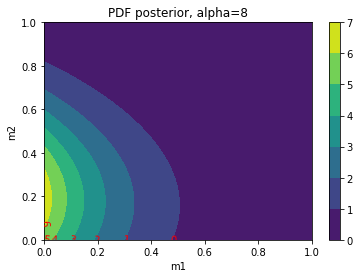

In [13]:
#--------------Gráfica de la PDF posterior conjunta--------------

c=plt.contourf(M1,M2,sigmMb)
plt.clabel(c,fontsize=10,colors='red',inline=True)
plt.contourf(M1,M2,sigmMb)
plt.xlabel("m1")
plt.ylabel("m2")
plt.title("PDF posterior, alpha="+str(alpha))
plt.colorbar()
plt.show()

In [14]:
#Se comprueba que las PDF marginales sean distribuciones de probabilidad, integrando y buscando obtener un volumen cercano a 1

#Se muestra la integral de la marginal para el parámetro m1
print(np.trapz(sigmMb1,x=m1,dx=(m1[1]-m1[0])))
#Se muestra la integral de la marginal para el parámetro m2
print(np.trapz(sigmMb2,x=m2,dx=(m2[1]-m2[0])))

[1.00000408]
[0.99999897]


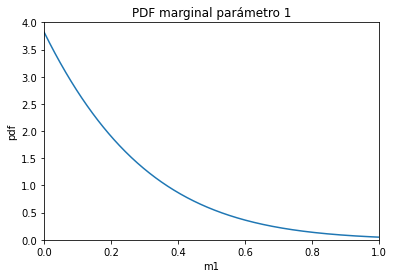

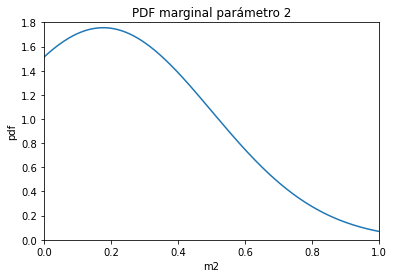

In [15]:
#--------------Gráficas de las Marginales--------------

plt.plot(m1,sigmMb1[0])
plt.xlim(0,1)
plt.ylim(0,4)
plt.xlabel("m1")
plt.ylabel("pdf")
plt.title("PDF marginal parámetro 1")
plt.show()

plt.plot(m2,sigmMb2[0])
plt.xlim(0,1)
plt.ylim(0,1.8)
plt.xlabel("m2")
plt.ylabel("pdf")
plt.title("PDF marginal parámetro 2")
plt.show()

In [16]:
#------------------------------------Resolucion usando MCMC------------------------------------

In [17]:
#Se define una semilla de números aleatorios para generar resultados reproducibles
np.random.seed(seed=233423)
#Se define una propuesta inicial [parámetro 1, parámetro 2]
p0=[0.5,0.5]
#La propuesta se convierte de una lista a un objeto numpy array
p0=np.array(p0)
#Se define un número de repeticiondes del MCMC
Nc=5*(10**5)
#Se define un arreglo para los datos generados con el muestreo
MCMC=np.zeros([Nc, len(p0)]) 
#Se define un arreglo para las muestras de la posterior
ln_probs = np.zeros(Nc) 

#Se asigna la primer propuesta el primer elemento de la cadena 
MCMC[0]=p0  

#Se toma un tiempo de inicio para medir el tiempo de ejecución con el método MCMC 
start_MCMC=time.perf_counter()
#Factor de normalización para la verosimilitud
Kd=1/((np.linalg.det(Cd))*(2*np.pi)**(Nm))**(0.5)
#Factor de normalización para la apriori
Km=1/((np.linalg.det(Cm))*(2*np.pi)**(Nm))**(0.5)

#Se define la primer muestra de la posterior a partir de la primer propuesta para los parámetros
ln_probs[0]=posterior(p0[0],p0[1],G,d,m0,Cdinv,Cminv,Kd,Km)
    
#Ciclo que realiza el muestreo con MCMC
for i in range(1,Nc):
    #Se calculan las perturbaciones para los parámetros extraidas de distribuciones normales truncadas a manera de obtener únicamente muestras dentro del espacio paramétrico.    
    pertm1=truncnorm.rvs(-(MCMC[i-1,0]-a1),b1-MCMC[i-1,0],loc=0, scale=1) 
    pertm2=truncnorm.rvs(-(MCMC[i-1,1]-a2),b2-MCMC[i-1,1],loc=0, scale=1) 
    #Las perturbaciones para ambos parámetros se introducen en un arreglo numpy
    pert=np.array([pertm1,pertm2])
    #Se perturban los parámetros
    propuesta=MCMC[i-1]+pert
    #Se obtiene la distribución posterior de los parámetros perturbados
    Newlnprob=posterior(propuesta[0],propuesta[1],G,d,m0,Cdinv,Cminv,Kd,Km)
    #Se obtiene la relación entre los parámetros perturbados y los de la iteración anterior
    Ratiolnprob=Newlnprob-ln_probs[i-1]
    #Criterio de metrópolis
    if (Ratiolnprob > 0) or (Ratiolnprob > np.log(np.random.uniform())):
        MCMC[i] = propuesta
        ln_probs[i] = Newlnprob
    else:
        MCMC[i]=MCMC[i-1]
        ln_probs[i]=ln_probs[i-1]

#Se toma el tiempo final para medir el tiempo de ejecución con el método MCMC 
end_MCMC=time.perf_counter()
#Se calcula el tiempo de ejecución con el método MCMC
t_MCMC=end_MCMC-start_MCMC

In [18]:
#Se muestra el tiempo de ejecución empleando el método MCMC
print("Tiempo de ejecución MCMC:",t_MCMC)

Tiempo de ejecución MCMC: 237.48855991000164


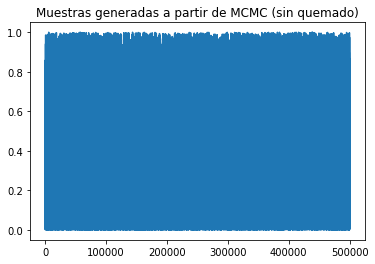

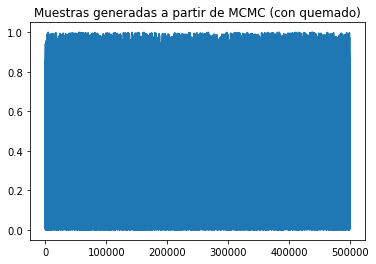

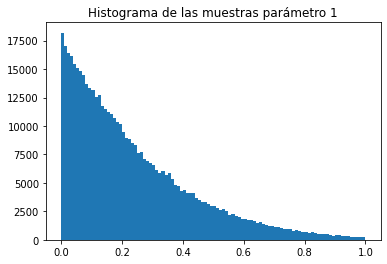

In [19]:
#Se despliegan las muestras generadas a partir de MCMC para el parámetro 1

plt.plot(MCMC[:,0],label="Muestras de la cadena")
plt.title("Muestras generadas a partir de MCMC (sin quemado)")
plt.show()

MCMC1=MCMC[1000:]

plt.plot(MCMC1[:,0],label="Muestras de la cadena")
plt.title("Muestras generadas a partir de MCMC (con quemado)")
plt.show()

plt.hist(MCMC1[:,0],bins=100)
plt.title("Histograma de las muestras parámetro 1")
plt.show()

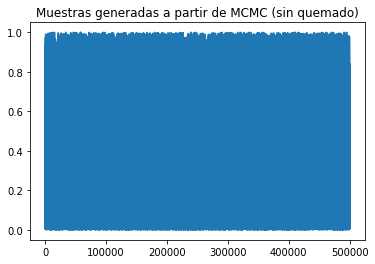

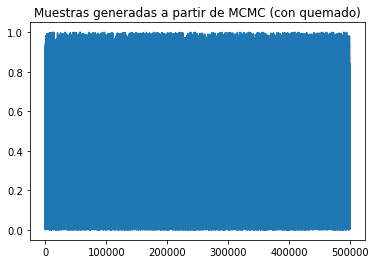

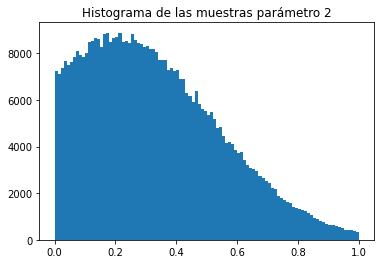

In [20]:
#Se despliegan las muestras generadas a partir de MCMC para el parámetro 2

plt.plot(MCMC[:,1])
plt.title("Muestras generadas a partir de MCMC (sin quemado)")
plt.show()

MCMC1=MCMC[1000:]

plt.plot(MCMC1[:,1])
plt.title("Muestras generadas a partir de MCMC (con quemado)")
plt.show()

plt.hist(MCMC1[:,1],bins=100)
plt.title("Histograma de las muestras parámetro 2")
plt.show()

In [21]:
#Se define una discretización del rango de valores para el primer parámetro
m1d=np.arange(a1,b1,0.05)
#Se define una discretización del rango de valores para el segundo parámetro
m2d=np.arange(a2,b2,0.05)
#Se define un mallado para el espacio de parámetros
M1d,M2d=np.meshgrid(m1d, m2d)

In [22]:
#Se define un arreglo para realizar el conteo del número de muestras que entran en cada celda del espacio discretizado
SigmaMCMC=np.zeros((len(m1d),len(m2d)))
#Se toma un tiempo de inicio para medir el tiempo de ejecución
start_malla=time.perf_counter()

#Se inician tres ciclos anidados para asignar cada muestra a la celda correspondiente del espacio de parámetros
for i in range(0,len(m1d)-1): #Se recorre el espacio parámetrico en dirección del primer parámetro
    for j in range(0,len(m2d)-1): #Se recorre el espacio parámetrico en dirección del segundo parámetro
        for k in range(0,len(MCMC[:,1])): #Se recorrel las muestras simuladas
            #Se verifica si la k-esima muestra corresponde a la celda correspondiente 
            if (MCMC[k,0]>=m1d[i] and MCMC[k,0]<m1d[i+1] and MCMC[k,1]>=m2d[j] and MCMC[k,1]<m2d[j+1]):
                #Se cuenta el número de muestras que entran en la celda correspondiente
                SigmaMCMC[i,j]=SigmaMCMC[i,j]+1
                #Se consideran las muestras que ya fueron asignadas
                np.delete(MCMC, k, axis=0)
                
#Se toma el tiempo final para medir el tiempo de ejecución
end_malla=time.perf_counter()
#Se calcula el tiempo de ejecución
t_malla=end_malla-start_malla

In [23]:
#Se muestra el tiempo de ejecución 
print("Tiempo de ejecución para la malla:",t_malla)

Tiempo de ejecución para la malla: 701.781315907001


In [24]:
#Se determina el delta de área del espacio de parámetros
dA=((m1d[1]-m1d[0])*(m2d[1]-m2d[0]))
#Se obtiene el delta del intervalo de truncamiento para el parámetro 1
dl1=m1d[1]-m1d[0]
#Se obtiene el delta del intervalo de truncamiento para el parámetro 2
dl2=m2d[1]-m2d[0]
#Se multiplica el conteo de muestras por el delta de área
SigmaMCMC=SigmaMCMC*dA
#Se determina el factor de normalización de la posterior
norm_factor=np.sum(SigmaMCMC)
#Se normaliza la posterior
SigmaMCMC=SigmaMCMC/norm_factor/dA
#Se corrobora que la posterior cumple con la definición de una distribución de probabilidad
print(np.sum(SigmaMCMC)*dA)

0.9999999999999999


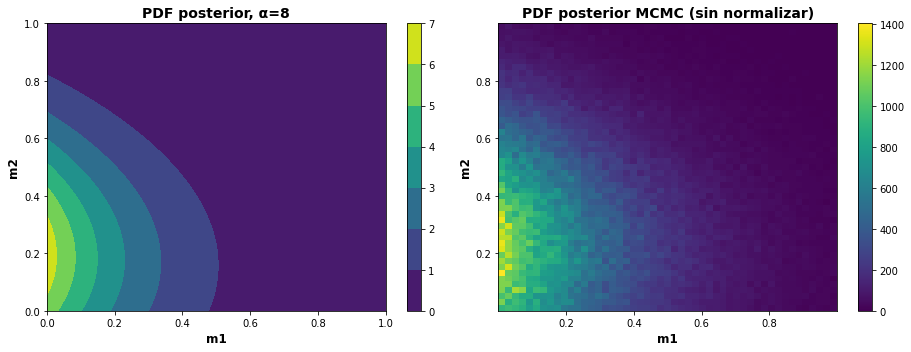

In [25]:
#Se muestra la comparación de las posteriores obtenidas con ambos métodos 

m1_bins=np.linspace(np.min(MCMC[:,0]), np.max(MCMC[:,0]), 50) 
m2_bins=np.linspace(np.min(MCMC[:,1]), np.max(MCMC[:,1]), 50) 

fig, axs = plt.subplots(1, 2,figsize=(13, 5))
f1=axs[0].contourf(M1,M2,sigmMb)
axs[0].set_ylabel("m2",fontsize=12,fontweight=600)
axs[0].set_xlabel("m1",fontsize=12,fontweight=600)
axs[0].set_title("PDF posterior, α="+str(alpha),fontsize=14,fontweight=600)
fig.colorbar(f1, ax=axs[0])

f2=axs[1].hist2d(MCMC[:,0], MCMC[:,1],bins =[m1_bins, m2_bins]) 
axs[1].set_ylabel("m2",fontsize=12,fontweight=600)
axs[1].set_xlabel("m1",fontsize=12,fontweight=600)
axs[1].set_title("PDF posterior MCMC (sin normalizar)", fontsize=14, fontweight=550)

fig.colorbar(f2[3], ax=axs[1])
plt.tight_layout()

#plt.savefig("PDF_Conj_sintetico.png",dpi=400,bbox_inches='tight')

plt.show()


0.9999999999999999
0.9999999999999999


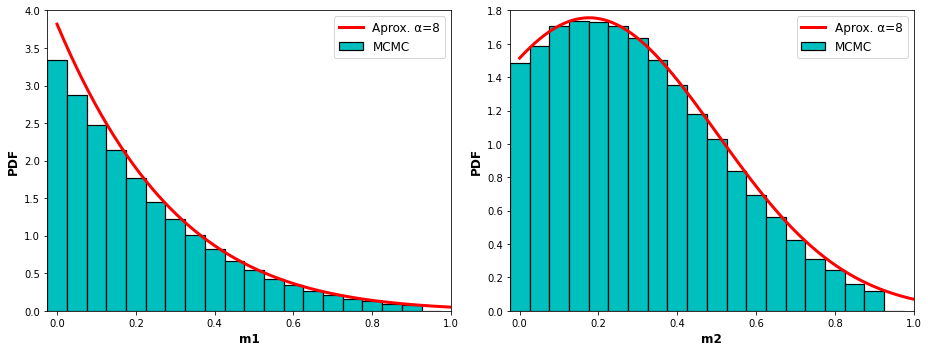

In [26]:
#Se muestra la comparación de las marginales obtenidas con ambos métodos 

SigMarg1=np.sum((SigmaMCMC)*dl2,axis=1)
print(np.sum(SigMarg1*dl1))

SigMarg2=np.sum((SigmaMCMC)*dl1,axis=0)
print(np.sum(SigMarg2*dl2))

fig, axs = plt.subplots(1, 2,figsize=(13, 5))
axs[0].bar(m1d,SigMarg1,width=0.05,edgecolor="k",color="c",linewidth=1.2,label="MCMC")
axs[0].plot(m1,sigmMb1[0],color="r",label="Aprox. α=8",linewidth=3)
axs[0].set_xlim([-0.025,1])
axs[0].set_ylim([0,4])
axs[0].set_ylabel("PDF",fontsize=12,fontweight=600)
axs[0].set_xlabel("m1",fontsize=12,fontweight=600)
axs[0].legend(prop={'size': 12})

axs[1].bar(m2d,SigMarg2,width=0.05,edgecolor="k",color="c",linewidth=1.2,label="MCMC")
axs[1].plot(m2,sigmMb2[0],color="r",label="Aprox. α=8",linewidth=3)
axs[1].set_xlim([-0.025,1])
axs[1].set_ylim([0,1.8])
axs[1].set_ylabel("PDF",fontsize=12,fontweight=600)
axs[1].set_xlabel("m2",fontsize=12,fontweight=600)
axs[1].legend(prop={'size': 12})

plt.tight_layout()
#plt.savefig("PDF_marg_sintetico.png",dpi=400,bbox_inches='tight')
plt.show()


In [27]:
#Se obtiene la media de la marginal del parámetro 1 (estrategia semianalítica)
MediaPDF=np.trapz(sigmMb1[0]*m1,x=m1,dx=(m1[1]-m1[0]))
#Se obtiene la varianza de la marginal del parámetro 1 (estrategia semianalítica)
VarPDF=np.trapz(sigmMb1[0]*(m1-MediaPDF)**2,x=m1,dx=(m1[1]-m1[0]))

In [28]:
#Se obtiene la media de la marginal del parámetro 2 (estrategia semianalítica)
MediaPDF1=np.trapz(sigmMb2[0]*m2,x=m2,dx=(m2[1]-m2[0]))
#Se obtiene la varianza de la marginal del parámetro 2 (estrategia semianalítica)
VarPDF1=np.trapz(sigmMb2[0]*(m2-MediaPDF1)**2,x=m2,dx=(m2[1]-m2[0]))

In [29]:
#Estadísticas Nocquet

print("        m1","     m2")
print("Media",round(MediaPDF,3),"/",round(MediaPDF1,3))
#Para m2
print("Std  ",round(VarPDF**(0.5),3),"/",round(VarPDF1**(0.5),3))

        m1      m2
Media 0.229 / 0.328
Std   0.2 / 0.219


In [30]:
#Estadísticas MCMC
#para m1
print("        m1","     m2")
print("Media",round(np.mean(MCMC1[:,0]),3),"/",round(np.mean(MCMC1[:,1]),3))
#Para m2
print("std  ",round(np.std(MCMC1[:,0]),3),"/",round(np.std(MCMC1[:,1]),3))

        m1      m2
Media 0.235 / 0.332
std   0.2 / 0.217
